In [1]:
import os
assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook settings > Hardware accelerator'

In [2]:
!pip install cloud-tpu-client==0.10 torch==1.11.0 https://storage.googleapis.com/tpu-pytorch/wheels/colab/torch_xla-1.11-cp37-cp37m-linux_x86_64.whl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 152.9 MB 40 kB/s 
     |████████████████████████████████| 57 kB 2.9 MB/s 
  Attempting uninstall: google-api-python-client
    Found existing installation: google-api-python-client 1.12.11
    Uninstalling google-api-python-client-1.12.11:
      Successfully uninstalled google-api-python-client-1.12.11
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
earthengine-api 0.1.315 requires google-api-python-client<2,>=1.12.1, but you have google-api-python-client 1.8.0 which is incompatible.


In [3]:
from PIL import Image
import numpy as np
import hashlib
import os
import sys
import torch
import io
import cv2

import torch

# imports the torch_xla package
import torch_xla
import torch_xla.core.xla_model as xm

import torch_xla.distributed.data_parallel as dp
import torch_xla.distributed.xla_multiprocessing as xmp
import torch_xla.distributed.parallel_loader as pl
import torch_xla.utils.tf_record_reader as tfrr

NUM_KEYPOINTS = 9

In [4]:
def decode(example):
  w = example['image/width'].item()
  h = example['image/height'].item()
  points = example['point_2d'].numpy()
  num_instances = example['instance_num'].item()
  # print('%%%%%%%%%%%')
  #print(points.shape)
  points = points.reshape(num_instances, NUM_KEYPOINTS, 3)
  #print(points.shape)
  #print('%%%%%%%%%%%')
  image_data = example['image/encoded'].numpy().tobytes()
  image = Image.open(io.BytesIO(image_data))
  npa = np.asarray(image)
  return torch.from_numpy(npa), points, num_instances

In [5]:
%matplotlib inline
# https://stackoverflow.com/questions/11159436/multiple-figures-in-a-single-window
import matplotlib.pyplot as plt

RADIUS = 10

colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (128, 128, 0), (128, 0, 128), 
          (0, 128, 128), (255, 255, 255), (0, 0, 0)]
EDGES = [
  [1, 5], [2, 6], [3, 7], [4, 8],  # lines along x-axis
  [1, 3], [5, 7], [2, 4], [6, 8],  # lines along y-axis
  [1, 2], [3, 4], [5, 6], [7, 8]   # lines along z-axis
]

def get_x_y(points_2d, num_instances):
    x_min = []
    y_min = []
    x_max = []
    y_max = []

    for instance in range(num_instances):
        x_min.append(min(points_2d[instance][:, 0]))
        x_max.append(max(points_2d[instance][:, 0]))
        y_min.append(min(points_2d[instance][:, 1]))
        y_max.append(max(points_2d[instance][:, 1]))
    
    print(x_min)

    return x_min, y_min, x_max, y_max

def show_3d_bounding_box(path, num_samples):
  count = 0
  transforms = {}  
  r = tfrr.TfRecordReader(path, compression='', transforms=transforms)
  # print(r)
  fig, ax = plt.subplots(1, 10, figsize = (12, 16))
  
  for i in range(num_samples):
    example = r.read_example()
    # print(example)
    if not example: break
    img_tensor, keypoints, num_instances = decode(example)
    image_clone = img_tensor

    for object_id in range(num_instances):
      w = 480
      h = 640
      # for kp_id in range(NUM_KEYPOINTS):
      #   kp_pixel = keypoints[object_id, kp_id, :]
      #   cv2.circle(image_clone.numpy(), (int(w  * kp_pixel[0]), int(h * kp_pixel[1])), 
      #             RADIUS, colors[object_id % len(colors)], -1)
      # for edge in EDGES:
      #   start_kp = keypoints[object_id, edge[0], :]
      #   start_x = int(w * start_kp[0])
      #   start_y = int(h * start_kp[1])
        
      #   end_kp = keypoints[object_id, edge[1], :]
      #   end_x = int(w * end_kp[0])
      #   end_y = int(h * end_kp[1])

      #   cv2.line(image_clone.numpy(), (start_x, start_y), (end_x, end_y), 
      #                 colors[object_id % len(colors)], 1)

    x_min, y_min, x_max, y_max = get_x_y(keypoints, num_instances)

    for i in range(len(x_min)):
      print('HERE')
      cv2.line(image_clone.numpy(), (int(w * x_min[i]), int(h * y_min[i])), (int(w * x_min[i]), int(h * y_max[i])), (0, 255 if i != 0 else 0, 255 - 125 * i), 5)
      cv2.line(image_clone.numpy(), (int(w * x_min[i]), int(h * y_min[i])), (int(w * x_max[i]), int(h * y_min[i])), (0, 255 if i != 0 else 0, 255 - 125 * i), 5)
      cv2.line(image_clone.numpy(), (int(w * x_min[i]), int(h * y_max[i])), (int(w * x_max[i]), int(h * y_max[i])), (0, 255 if i != 0 else 0, 255 - 125 * i), 5)
      cv2.line(image_clone.numpy(), (int(w * x_max[i]), int(h * y_min[i])), (int(w * x_max[i]), int(h * y_max[i])), (0, 255 if i != 0 else 0, 255 - 125 * i), 5)

    cv2_imshow(image_clone.numpy())
    # ax[i].grid(False)
    # ax[i].imshow(image_clone);
    # ax[i].get_xaxis().set_visible(False)
    # ax[i].get_yaxis().set_visible(False)

  # fig.tight_layout();
  # plt.show()

In [ ]:
# We only use tensorflow for the glob function. 
import tensorflow as tf
from google.colab.patches import cv2_imshow

objectron_buckett = 'gs://objectron/v1/records_shuffled'
training_shards   = tf.io.gfile.glob(objectron_buckett + '/bottle/bottle_train*')

for i in range(1):
  # Visualize the bounding box on the first 10 sample from this shard.
  show_3d_bounding_box(path = training_shards[i], num_samples = 10)

In [ ]:
training_shards

['gs://objectron/v1/records_shuffled/cup/cup_train-00000-of-00995',
 'gs://objectron/v1/records_shuffled/cup/cup_train-00001-of-00995',
 'gs://objectron/v1/records_shuffled/cup/cup_train-00002-of-00995',
 'gs://objectron/v1/records_shuffled/cup/cup_train-00003-of-00995',
 'gs://objectron/v1/records_shuffled/cup/cup_train-00004-of-00995',
 'gs://objectron/v1/records_shuffled/cup/cup_train-00005-of-00995',
 'gs://objectron/v1/records_shuffled/cup/cup_train-00006-of-00995',
 'gs://objectron/v1/records_shuffled/cup/cup_train-00007-of-00995',
 'gs://objectron/v1/records_shuffled/cup/cup_train-00008-of-00995',
 'gs://objectron/v1/records_shuffled/cup/cup_train-00009-of-00995',
 'gs://objectron/v1/records_shuffled/cup/cup_train-00010-of-00995',
 'gs://objectron/v1/records_shuffled/cup/cup_train-00011-of-00995',
 'gs://objectron/v1/records_shuffled/cup/cup_train-00012-of-00995',
 'gs://objectron/v1/records_shuffled/cup/cup_train-00013-of-00995',
 'gs://objectron/v1/records_shuffled/cup/cup_tra

In [ ]:
training_shards[0]

'gs://objectron/v1/records_shuffled/cup/cup_train-00000-of-00995'

In [ ]:
def my_decode(path):

  transforms = {} 
  r = tfrr.TfRecordReader(path, compression='', transforms=transforms)

  example = r.read_example()

  points2d = example['point_2d'].numpy()
  points3d = example['point_3d'].numpy()
  points = example['point_2d'].numpy()
  print(points2d.shape)
  print(points3d.shape)
  # num_instances = example['instance_num'].item()
  # points = points.reshape(num_instances, NUM_KEYPOINTS, 3)
  # image_data = example['image/encoded'].numpy().tobytes()
  # image = Image.open(io.BytesIO(image_data))
  # npa = np.asarray(image)
  # return torch.from_numpy(npa), points, num_instances

In [ ]:
my_decode(path = training_shards[0])
my_decode(path = training_shards[1])
my_decode(path = training_shards[2])
my_decode(path = training_shards[3])

(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)


{'image/colorspace': tensor([82, 71, 66], dtype=torch.int8), 'object/translation': tensor([-0.0168, -0.0198, -0.3353]), 'camera/extrinsics': tensor([ -0.0885,  -0.9858,  -0.1430,   0.7045,  -0.9416,   0.0359,   0.3347,
         -1.3418,  -0.3248,   0.1643,  -0.9314, -19.8438,   0.0000,   0.0000,
          0.0000,   1.0000]), 'plane/center': tensor([ 0.0617, -0.0236, -0.3667]), 'image/format': tensor([112, 110, 103], dtype=torch.int8), 'camera/intrinsics': tensor([1.6023e+03, 0.0000e+00, 9.3570e+02, 0.0000e+00, 1.6023e+03, 7.1025e+02,
        0.0000e+00, 0.0000e+00, 1.0000e+00]), 'point_2d': tensor([0.4404, 0.4457, 0.3353, 0.3025, 0.5922, 0.3925, 0.3141, 0.6880, 0.3235,
        0.2889, 0.2135, 0.3297, 0.2997, 0.2319, 0.2607, 0.5298, 0.5814, 0.4099,
        0.5870, 0.6702, 0.3409, 0.5582, 0.2198, 0.3470, 0.6354, 0.2386, 0.2780]), 'object/orientation': tensor([-0.0378, -0.9275,  0.3719,  0.9767,  0.0444,  0.2099, -0.2112,  0.3712,
         0.9042]), 'image/id': tensor([56]), 'point_3d': t

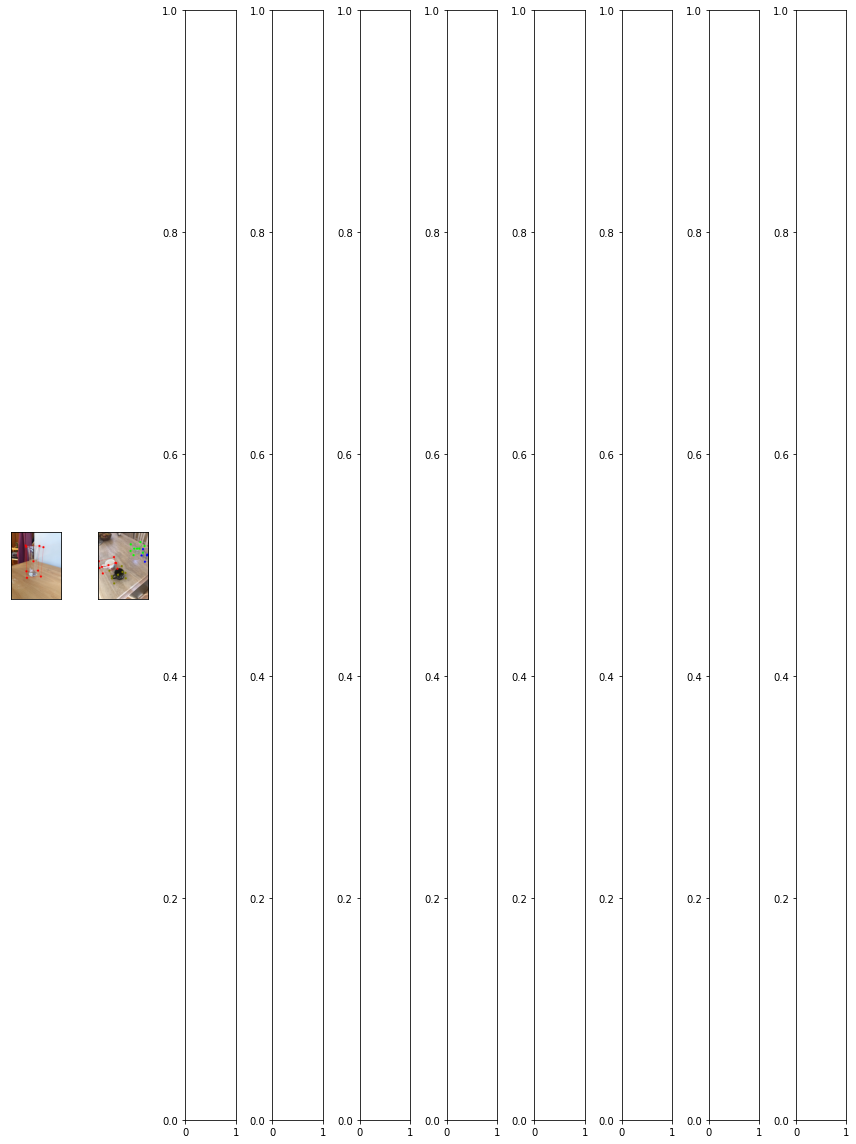

In [ ]:
show_3d_bounding_box(path = training_shards[0], num_samples = 2)